In [30]:
import numpy as np
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline
import GPy
import collections
import timeit
from multiprocessing import Pool
import time
from scipy.interpolate import splev, splprep
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

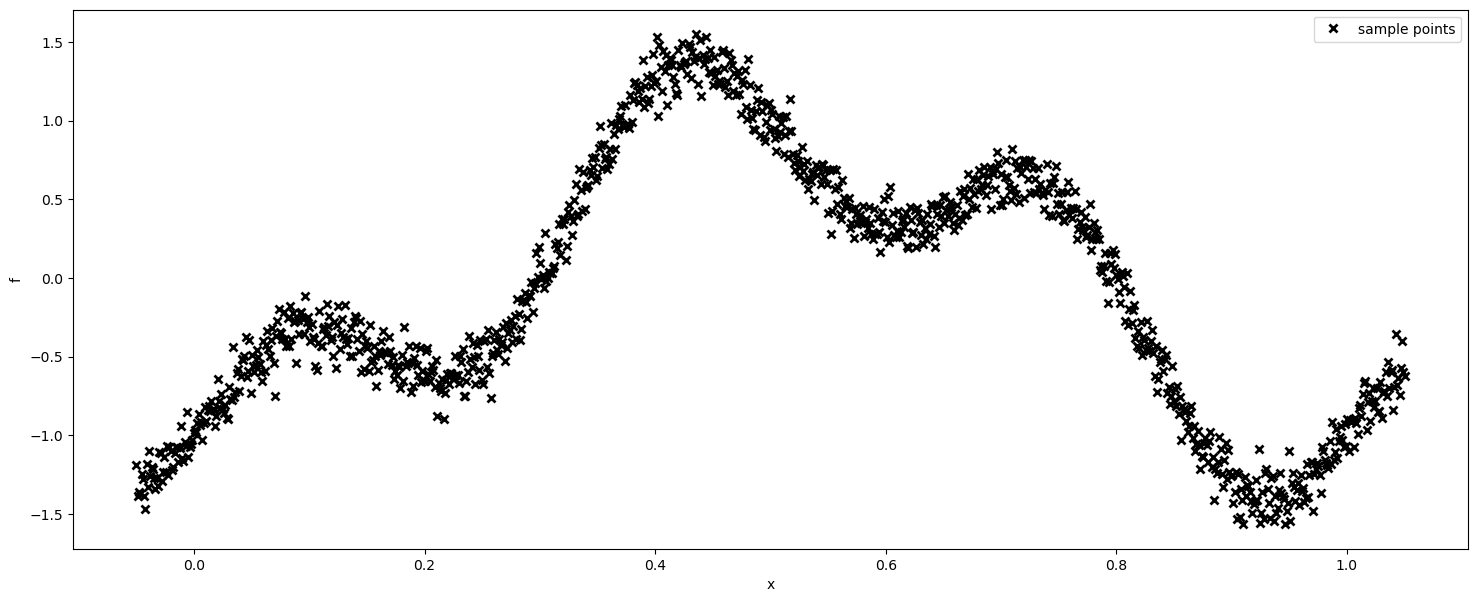

In [44]:
# lambda function, call f(x) to generate data
f = lambda x: -np.cos(2*np.pi*x) + 0.5*np.sin(6*np.pi*x)

# 10 equally spaced sample locations 
#X = np.linspace(0.05, 0.95, 10)[:,None]
# New test points to sample function from
X = np.linspace(-0.05, 1.05, 1000)[:, None]


# y = f(X) + epsilon
Y = f(X) + np.random.normal(0., 0.1, (1000,1)) # note that np.random.normal takes mean and s.d. (not variance), 0.1^2 = 0.01

# Setup our figure environment
plt.figure(figsize=(18, 7))

# Plot observations
plt.plot(X, Y, "kx", mew=2)

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

In [17]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)),
                     m[:,0] + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])

In [4]:
import multiprocessing as mp

In [37]:
def estimate(X, Y):
    #k2 = GPy.kern.Bias(input_dim=1, variance=2)
    k1 = GPy.kern.RBF(1, variance=1, lengthscale=0.8, name="rbf")
    m = GPy.models.GPRegression(X, Y, k1)
    #m.rbf.lengthscale.fix()
    m.rbf.variance.fix()
    m.Gaussian_noise.variance.fix()
    m.optimize(max_iters=100)
    mean, cov = m.predict_noiseless(X)
    return mean

In [1]:
def estimate_x3(X,Y):
    m1 = estimate(X,Y)
    m2 = estimate(X+X,Y+Y)
    m3 = estimate(X*3,Y*3)
    m4 = estimate(X,Y)
    m5 = estimate(X+X,Y+Y)
    m6 = estimate(X*3,Y*3)
        
    return np.hstack((m1,m2,m3,m4,m5,m6))


In [2]:
def estimate_parallel(X,Y):
    data_list = [(X, Y), (X+X, Y+Y), (X*3, Y*3), (X, Y), (X+X, Y+Y), (X*3, Y*3)]
    pool = mp.Pool(processes=mp.cpu_count())
    results = pool.starmap(estimate, data_list)
    
    
    
    with Pool(4) as p:
        results = p.starmap(estimate, data_list)
    return results
    


In [61]:
def estimate_3dim(X,Y):
    X3 = np.hstack((X,X+X,X*3))
    Y3 = np.hstack((Y,Y+Y,Y*3))
    
    k1 = GPy.kern.RBF(3, variance=1, lengthscale=0.8, name="rbf1")
    
    
    m = GPy.models.GPMultioutRegression(X3, Y3, 1)
    
    mean, cov = m.predict_noiseless(X3)
    return mean

In [62]:

t0 = time.time()
estimate_3dim(X,Y)
t1 = time.time()

print('took {} ms'.format((t1-t0)*1000))


Intializing with GP...
Fit Sparse GP...
Fit BGPLVM...
Done.


ValueError: operands could not be broadcast together with shapes (3,3) (10,10) 

In [45]:
t0 = time.time()
estimate(X,Y)
t1 = time.time()

print('took {} ms'.format((t1-t0)*1000))

took 4608.402252197266 ms


In [46]:

t0 = time.time()
estimate_x3(X,Y)
t1 = time.time()

print('took {} ms'.format((t1-t0)*1000))

took 12737.91241645813 ms


In [47]:

t0 = time.time()
estimate_parallel(X,Y)
t1 = time.time()

print('took {} ms'.format((t1-t0)*1000))


took 10888.593673706055 ms


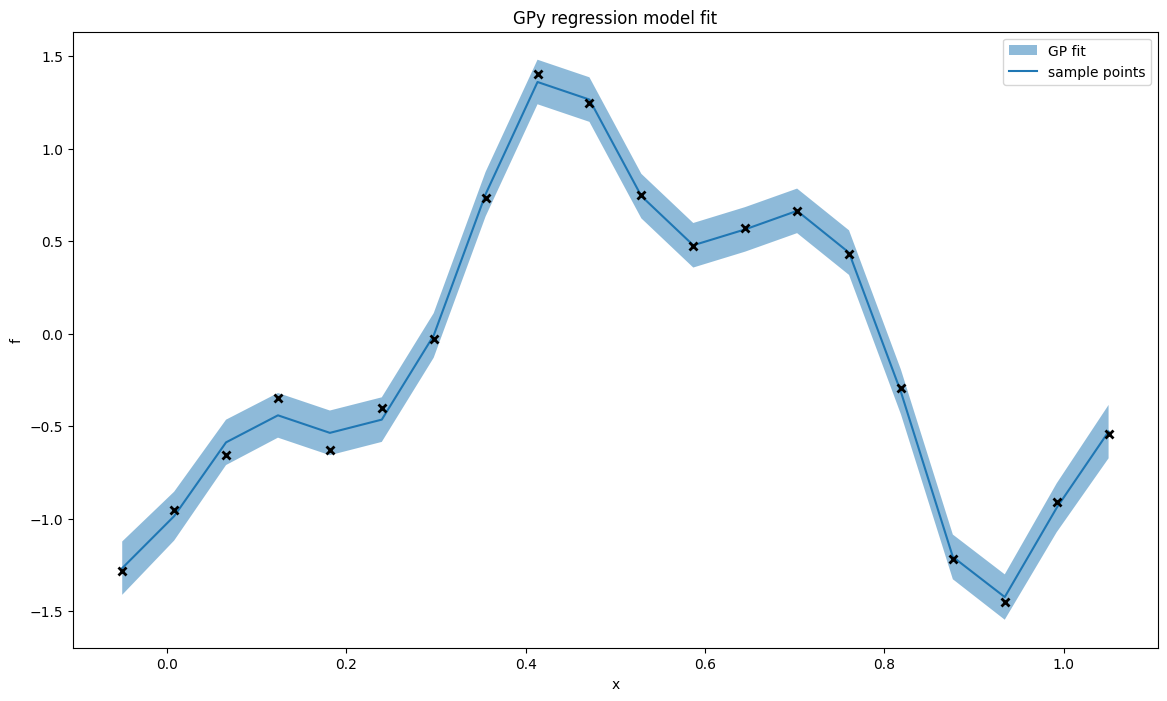

In [73]:
# Use GPy model to calculate the mean and covariance of the fit at Xnew
mean, Cov = m.predict_noiseless(X, full_cov=True)

plt.figure(figsize=(14, 8))

# Plot the GP fit mean and covariance
plot_gp(X, mean, Cov, training_points=(X,Y))
plt.title("GPy regression model fit");

In [82]:
print(mean)

[[-1.11273937]]


In [139]:
def predict_next_y(x, y, new_x):
    """
    Predict the next y for a given x using GPy.

    Parameters:
    x (numpy array): Input data from the last 20 timesteps.
    y (numpy array): Output data from the last 20 timesteps.
    new_x (numpy array): New input for which to predict the output.

    Returns:
    numpy array: Predicted output for the new input.
    """
    # Create a GPRegression model with an RBF kernel
    
    kernel = GPy.kern.RBF(input_dim=1, variance=0.8, lengthscale=1)
    model = GPy.models.GPRegression(x, y, kernel)
    
    # Optimize the model parameters
    model.optimize()
    
    # Predict the mean and variance of the output for the new input
    mean, var = model.predict(new_x)

    # Return the predicted mean
    return mean, var

In [140]:

x = np.array([0,1,2,3,4,5,6,7,8,9])
y = np.array([1,2,3,4,5,6,7,8,9,10])

prediction0, var0 = predict_next_y(x.reshape(-1,1),y.reshape(-1,1), np.array([[100]]))
print(prediction0)
print(var0)

[[97.61243911]]
[[18.40486478]]


In [182]:
def generate_trajectory(points, d_points):
    """generates a smooth trajectory from an array of given points

    Args:
        points (np.ndarray): input points with arbitrary distance
        d_points (float): maximum distance of output points

    Returns:
        np.ndarray: array of points with maximum distance of d_points
    """
    # Calculate the total distance of the trajectory
    total_distance = np.sum(np.linalg.norm(np.diff(points, axis=0), axis=1))

    # Calculate the number of points needed for the trajectory
    n_points = int(total_distance / d_points) + 1

    # Prepare the input for the interpolation function
    #t = np.arange(len(points))
    points = points.T
    
    # Perform the interpolation
    tck, u = splprep(points, s=0.1)
    u_new = np.linspace(u.min(), u.max(), n_points)
    x_new, y_new, z_new = splev(u_new, tck)

    # Return the interpolated points
    return np.array([x_new, y_new, z_new]).T

In [189]:
def generate_trajectory(points, d_points):
    if len(points) < 4:
        # If there are less than 4 points, use linear spline
        
        points = points.T
        tck, u = splprep(points, k=1, s=0)
    else:
        # If there are 4 or more points, use cubic spline
        
        points = points.T
        tck, u = splprep(points, s=0)

    # Calculate the total distance of the trajectory
    total_distance = np.sum(np.linalg.norm(np.diff(points, axis=0), axis=1))

    # Calculate the number of points needed for the trajectory
    n_points = int(total_distance / d_points) + 1

    # Perform the interpolation
    u_new = np.linspace(u.min(), u.max(), n_points)
    x_new, y_new, z_new = splev(u_new, tck)

    # Return the interpolated points
    return np.array([x_new, y_new, z_new]).T


In [198]:

def generate_trajectory(points, d_points):
    trajectory = [points[0]]
    for i in range(len(points) - 1):
        vector = points[i + 1] - points[i]
        distance = np.linalg.norm(vector)
        num_points = int(np.ceil(distance / d_points))
        for j in range(1, num_points + 1):
            point = points[i] + j * vector / num_points
            trajectory.append(point)
    trajectory.append(points[-1])
    return np.array(trajectory)

In [222]:
def generate_trajectory(points, d_points, d_yaw):
    trajectory = []
    for i in range(len(points) - 1):
        vector = points[i + 1][:3] - points[i][:3]
        distance = np.linalg.norm(vector)
        yaw_diff = points[i + 1][3] - points[i][3]
        if yaw_diff > 180:
            yaw_diff -= 360
        elif yaw_diff < -180:
            yaw_diff += 360
        num_points = max(int(np.ceil(distance / d_points)), int(np.ceil(np.abs(yaw_diff) / d_yaw)))
        for j in range(0, num_points + 1):
            point = points[i][:3] + j * vector / num_points
            yaw = points[i][3] + j * yaw_diff / num_points
            if yaw > 360:
                yaw -= 360
            elif yaw < -360:
                yaw += 360
            trajectory.append(np.append(point, yaw))
    
    return np.array(trajectory)

In [152]:


def plot_trajectory(trajectory):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

In [74]:
points = np.array([
    [0, 0, 0, 0],
    [1, 0, 0, -190],
    [1, 1, 0, 20],
    [1, 1, 0, -20]
])
print(points[:,1:])
d_points = 0.1
d_yaw = 10
print(np.diff(points, axis=0))
trajectory = generate_trajectory(points, d_points, d_yaw)
print(trajectory)
#plot_trajectory(trajectory)

[[   0    0    0]
 [   0    0 -190]
 [   1    0   20]
 [   1    0  -20]]
[[   1    0    0 -190]
 [   0    1    0  210]
 [   0    0    0  -40]]


NameError: name 'generate_trajectory' is not defined

In [167]:
a = np.array([1,2,3])
b = np.array([4,5,6])

l = []
l.append(a)
l.append(b)

print(np.asarray(l))


[[1 2 3]
 [4 5 6]]


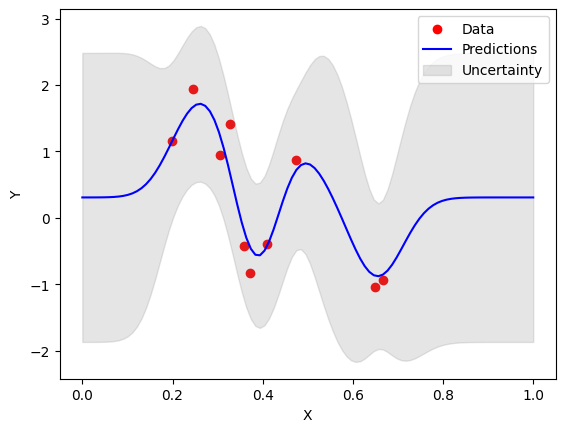

In [ ]:


# Generate some example data
X = np.random.rand(10, 1)  # Input features
Y = np.sin(2 * np.pi * X) +  np.random.randn(10, 1)  # Observed data

# Define a non-zero mean function
mean_function = GPy.mappings.Constant(input_dim=1, output_dim=1, value=5)

# Create a GP regression model with the non-zero mean function
kernel = GPy.kern.RBF(input_dim=1)
model = GPy.models.GPRegression(X, Y, kernel, mean_function=mean_function)

# Optimize the model parameters
model.optimize()

# Make predictions for new input points
X_new = np.linspace(0, 1, 100)[:, None]
Y_pred, Y_var = model.predict(X_new)

# Plot the results
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X, Y, color='red', label='Data')
plt.plot(X_new, Y_pred, color='blue', label='Predictions')
plt.fill_between(X_new.flatten(), (Y_pred - 2 * np.sqrt(Y_var)).flatten(), (Y_pred + 2 * np.sqrt(Y_var)).flatten(), color='gray', alpha=0.2, label='Uncertainty')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


In [38]:
state_history = collections.deque(maxlen=20)

for i in range(20):
    state_history.append(np.array([1,2,3,4,5,6]))

    
data = np.asarray(list(state_history))[:,0:2]    
print(np.mean(data, axis=0))

[1. 2.]
